In [1]:
import dotenv
import email.message
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_datareader as oi
import pandas_datareader.data as web
import plotly.express as px
import plotly.graph_objects as go
import pymysql
import seaborn as sns
import smtplib
import sqlalchemy as db
from datetime import date
from datetime import datetime
from email import encoders
from email.mime.application import MIMEApplication
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from matplotlib import style
from pretty_html_table import build_table
from sklearn.preprocessing import MinMaxScaler
plt.style.use('seaborn-darkgrid')
dotenv.load_dotenv('senhas.env')
pd.options.display.max_columns=100
pd.options.display.float_format = '{:,.2f}'.format

## Importing Data

In [2]:
def import_data_yahoo(ticker, start_day="2008-01-01", end_day=date.today() ):
    result = web.DataReader(ticker, data_source="yahoo", start=start_day, end=end_day)
    result = pd.DataFrame(result).reset_index()
    return result.rename(columns={'High':f"{ticker}_High", 'Low':f"{ticker}_Low",
                                  'Open':f"{ticker}_Open", 'Close':f"{ticker}_Close",
                                  'Volume':f"{ticker}_Volume", 'Adj Close':f"{ticker}_Adj_Close"})

IVV is one of several ETFs that track the S&P 500 Index-delivers excellent large-cap exposure. 

In [3]:
ivv = import_data_yahoo('IVV')
ivv

,Date,IVV_High,IVV_Low,IVV_Open,IVV_Close,IVV_Volume,IVV_Adj_Close
0,2008-01-02,147.25,144.21,146.83,144.91,"3,629,200.00",108.62
1,2008-01-03,145.76,144.43,145.22,144.72,"1,896,800.00",108.48
2,2008-01-04,143.70,141.12,143.63,141.20,"2,294,300.00",105.84
3,2008-01-07,142.49,140.39,142.06,141.83,"3,724,400.00",106.31
4,2008-01-08,143.15,138.90,142.30,139.21,"3,035,700.00",104.35
...,...,...,...,...,...,...,...
3760,2022-12-07,397.32,393.62,394.42,394.85,"4,078,000.00",394.85
3761,2022-12-08,399.05,395.15,396.82,397.95,"2,484,500.00",397.95
3762,2022-12-09,399.34,394.85,396.64,395.01,"3,540,200.00",395.01
3763,2022-12-12,400.66,395.11,395.87,400.55,"4,997,900.00",400.55


SLYV is one fund in the small-cap value segment tracking the S&P SmallCap 600 Value Index. It tilts smaller than its benchmark and offers decent exposure to the small-cap value space. 

In [4]:
slyv = import_data_yahoo('SLYV')
slyv

,Date,SLYV_High,SLYV_Low,SLYV_Open,SLYV_Close,SLYV_Volume,SLYV_Adj_Close
0,2008-01-02,33.01,32.40,33.00,32.54,"21,800.00",21.27
1,2008-01-03,32.69,32.11,32.52,32.11,"48,600.00",20.99
2,2008-01-04,31.65,31.13,31.57,31.18,"65,800.00",20.39
3,2008-01-07,31.50,30.95,31.20,31.25,"38,400.00",20.43
4,2008-01-08,31.77,30.42,31.47,30.42,"22,200.00",19.88
...,...,...,...,...,...,...,...
3760,2022-12-07,77.56,76.64,76.98,76.65,"205,900.00",76.65
3761,2022-12-08,77.80,76.82,77.15,77.03,"166,200.00",77.03
3762,2022-12-09,77.03,76.16,76.71,76.16,"80,300.00",76.16
3763,2022-12-12,77.15,75.88,76.32,76.99,"194,600.00",76.99


VEA offers exposure to developed markets outside of North America, including Western Europe, Japan, and Australia.

In [5]:
vea = import_data_yahoo('VEA')
vea

,Date,VEA_High,VEA_Low,VEA_Open,VEA_Close,VEA_Volume,VEA_Adj_Close
0,2008-01-02,48.39,47.19,48.27,47.81,"688,200.00",30.94
1,2008-01-03,48.02,47.77,47.90,47.89,"225,300.00",31.00
2,2008-01-04,47.55,46.71,47.54,46.84,"411,100.00",30.32
3,2008-01-07,47.03,46.62,47.00,46.90,"759,900.00",30.36
4,2008-01-08,47.50,46.48,47.37,46.52,"368,600.00",30.11
...,...,...,...,...,...,...,...
3760,2022-12-07,42.99,42.65,42.80,42.79,"16,632,000.00",42.79
3761,2022-12-08,43.07,42.72,42.83,43.03,"13,719,300.00",43.03
3762,2022-12-09,43.38,43.02,43.11,43.06,"14,430,200.00",43.06
3763,2022-12-12,43.17,42.89,43.03,43.17,"13,482,000.00",43.17


VWO offers exposure to emerging markets. Given the opportunity to establish broad-based exposure to the developing economies of the world.

In [6]:
vwo = import_data_yahoo('VWO')
vwo

,Date,VWO_High,VWO_Low,VWO_Open,VWO_Close,VWO_Volume,VWO_Adj_Close
0,2008-01-02,52.98,51.31,52.12,52.00,"1,454,800.00",35.06
1,2008-01-03,52.54,52.02,52.35,52.50,"1,434,800.00",35.40
2,2008-01-04,52.11,50.37,51.79,50.76,"2,638,800.00",34.23
3,2008-01-07,51.46,50.33,51.00,51.17,"1,826,000.00",34.50
4,2008-01-08,52.95,50.89,51.97,51.12,"1,864,600.00",34.47
...,...,...,...,...,...,...,...
3760,2022-12-07,40.16,39.88,39.96,40.05,"13,380,600.00",40.05
3761,2022-12-08,40.65,40.31,40.45,40.51,"16,254,600.00",40.51
3762,2022-12-09,40.56,40.17,40.50,40.17,"10,962,700.00",40.17
3763,2022-12-12,40.06,39.71,40.05,40.06,"15,845,600.00",40.06


## Data Cleaning and Preprocessing

In [7]:
# Merging data into a single data frame.

df_etf = (ivv.merge(slyv).merge(vea).merge(vwo)).set_index('Date')
df_etf

,IVV_High,IVV_Low,IVV_Open,IVV_Close,IVV_Volume,IVV_Adj_Close,SLYV_High,SLYV_Low,SLYV_Open,SLYV_Close,SLYV_Volume,SLYV_Adj_Close,VEA_High,VEA_Low,VEA_Open,VEA_Close,VEA_Volume,VEA_Adj_Close,VWO_High,VWO_Low,VWO_Open,VWO_Close,VWO_Volume,VWO_Adj_Close
Date,,,,,,,,,,,,,,,,,,,,,,,,
2008-01-02,147.25,144.21,146.83,144.91,"3,629,200.00",108.62,33.01,32.40,33.00,32.54,"21,800.00",21.27,48.39,47.19,48.27,47.81,"688,200.00",30.94,52.98,51.31,52.12,52.00,"1,454,800.00",35.06
2008-01-03,145.76,144.43,145.22,144.72,"1,896,800.00",108.48,32.69,32.11,32.52,32.11,"48,600.00",20.99,48.02,47.77,47.90,47.89,"225,300.00",31.00,52.54,52.02,52.35,52.50,"1,434,800.00",35.40
2008-01-04,143.70,141.12,143.63,141.20,"2,294,300.00",105.84,31.65,31.13,31.57,31.18,"65,800.00",20.39,47.55,46.71,47.54,46.84,"411,100.00",30.32,52.11,50.37,51.79,50.76,"2,638,800.00",34.23
2008-01-07,142.49,140.39,142.06,141.83,"3,724,400.00",106.31,31.50,30.95,31.20,31.25,"38,400.00",20.43,47.03,46.62,47.00,46.90,"759,900.00",30.36,51.46,50.33,51.00,51.17,"1,826,000.00",34.50
2008-01-08,143.15,138.90,142.30,139.21,"3,035,700.00",104.35,31.77,30.42,31.47,30.42,"22,200.00",19.88,47.50,46.48,47.37,46.52,"368,600.00",30.11,52.95,50.89,51.97,51.12,"1,864,600.00",34.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-07,397.32,393.62,394.42,394.85,"4,078,000.00",394.85,77.56,76.64,76.98,76.65,"205,900.00",76.65,42.99,42.65,42.80,42.79,"16,632,000.00",42.79,40.16,39.88,39.96,40.05,"13,380,600.00",40.05
2022-12-08,399.05,395.15,396.82,397.95,"2,484,500.00",397.95,77.80,76.82,77.15,77.03,"166,200.00",77.03,43.07,42.72,42.83,43.03,"13,719,300.00",43.03,40.65,40.31,40.45,40.51,"16,254,600.00",40.51
2022-12-09,399.34,394.85,396.64,395.01,"3,540,200.00",395.01,77.03,76.16,76.71,76.16,"80,300.00",76.16,43.38,43.02,43.11,43.06,"14,430,200.00",43.06,40.56,40.17,40.50,40.17,"10,962,700.00",40.17


In [8]:
# Normalizing data for use in charts.

def price_normalize (df_name, column):
    pd.options.display.float_format = '{:,.5f}'.format
    convert = df_name.copy()
    convert[column] = MinMaxScaler().fit_transform(np.array(convert[column]).reshape(-1,1))
    return convert[['Date', column]]

In [9]:
ivv_norm = price_normalize(ivv, 'IVV_Adj_Close')
slyv_norm = price_normalize(slyv, 'SLYV_Adj_Close')
vea_norm = price_normalize(vea, 'VEA_Adj_Close')
vwo_norm = price_normalize(vwo, 'VWO_Adj_Close')

df_etf_norm = (ivv_norm.merge(slyv_norm).merge(vea_norm).merge(vwo_norm)).set_index('Date')
df_etf_norm

,IVV_Adj_Close,SLYV_Adj_Close,VEA_Adj_Close,VWO_Adj_Close
Date,,,,
2008-01-02,0.13343,0.14711,0.46579,0.54617
2008-01-03,0.13309,0.14354,0.46714,0.55434
2008-01-04,0.12684,0.13587,0.44946,0.52597
2008-01-07,0.12796,0.13645,0.45047,0.53251
2008-01-08,0.12330,0.12949,0.44408,0.53186
...,...,...,...,...
2022-12-07,0.81169,0.84940,0.77383,0.66717
2022-12-08,0.81903,0.85422,0.78008,0.67833
2022-12-09,0.81207,0.84319,0.78086,0.67008


In [10]:
pd.options.display.float_format = '{:,.2f}'.format

In [11]:
# table with data to be reported in a daily email.

df_5d = df_etf[['IVV_Adj_Close','SLYV_Adj_Close','VEA_Adj_Close','VWO_Adj_Close']][-5:]
df_5d

,IVV_Adj_Close,SLYV_Adj_Close,VEA_Adj_Close,VWO_Adj_Close
Date,,,,
2022-12-07,394.85,76.65,42.79,40.05
2022-12-08,397.95,77.03,43.03,40.51
2022-12-09,395.01,76.16,43.06,40.17
2022-12-12,400.55,76.99,43.17,40.06
2022-12-13,404.88,77.85,43.93,40.60


## Graphics 

A Bollinger Band is a technical analysis tool developed by John Bollinger for generating oversold or overbought signals. It is defined by a set of trendlines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of a security's price, but which can be adjusted to user preferences.

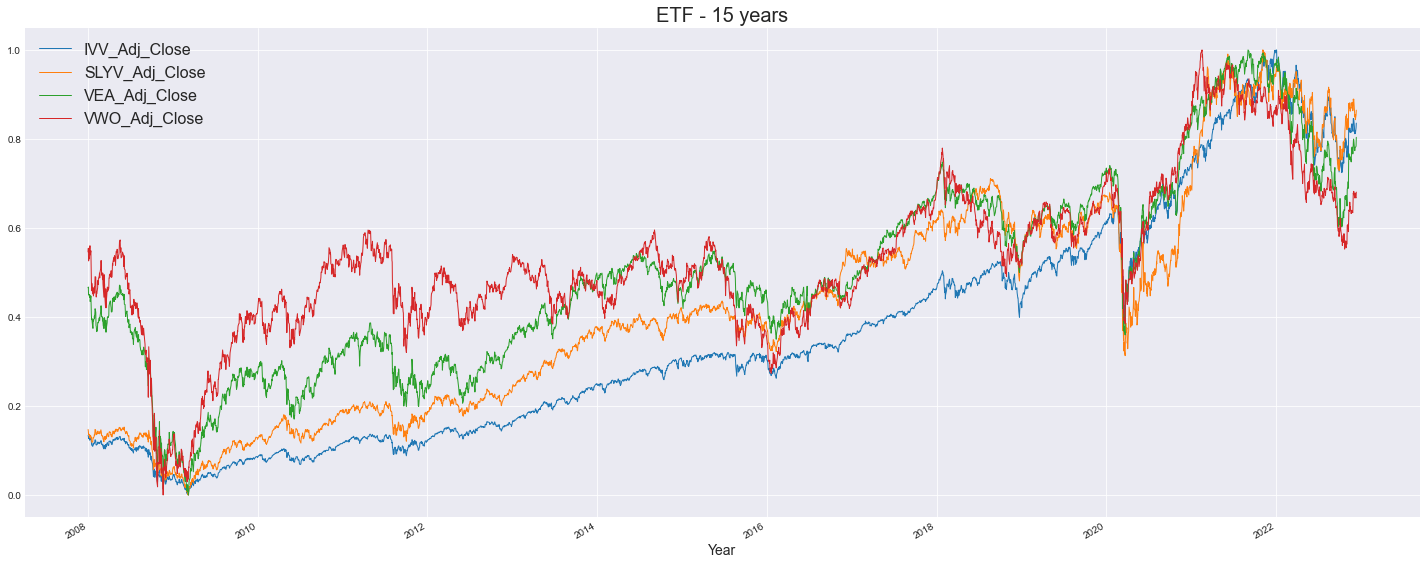

In [12]:
df = df_etf_norm.reset_index()
fig = df.plot(x='Date', y=['IVV_Adj_Close', 'SLYV_Adj_Close', 'VEA_Adj_Close',
            'VWO_Adj_Close'], kind="line", linewidth=1, figsize=(25, 10))
fig.set_title("ETF - 15 years", fontsize=20)
fig.set_xlabel("Year", fontsize=14)
fig.legend(fontsize=16);
plt.show()

In [13]:
def bollinger_band_table(ticker, back_days=180, end_day=date.today()):
    back = date.fromordinal(date.today().toordinal()-back_days)
    df = web.DataReader(ticker, data_source="yahoo", start=back, end=end_day)
    df = pd.DataFrame(df).reset_index()
    df['SMA'] = df['Close'].rolling(window=20).mean()
    df['STD'] = df['Close'].rolling(window=20).std()
    df['Upper Band'] = df['SMA'] + df['STD']*2
    df['Lower Band'] = df['SMA'] - df['STD']*2
    df = df[['Date','Close','SMA','Upper Band','Lower Band']]
    df.rename(columns={'Close':'Close Price','SMA':'20-day SMA'}, inplace=True)
    return df

In [14]:
def bollinger_band_chart(df, title):
    full_title = f'Bollinger Band - {title}'
    fig = (df.set_index('Date')).plot(figsize=(18,5))
    fig.set_title(full_title, fontsize=16)
    fig.set_xlabel("Year", fontsize=14)
    fig.legend(fontsize=10);
    return fig

In [15]:
ivv_bollinger_table = bollinger_band_table('IVV')
slyv_bollinger_table = bollinger_band_table('SLYV')
vea_bollinger_table = bollinger_band_table('VEA')
vwo_bollinger_table = bollinger_band_table('VWO')

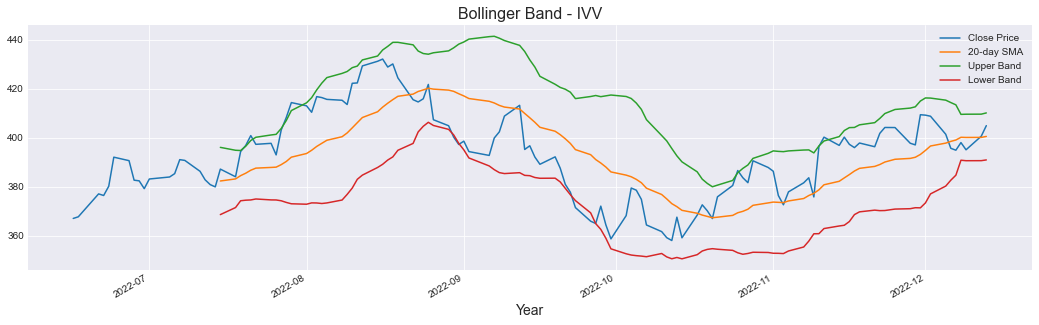

In [16]:
bollinger_band_chart(ivv_bollinger_table, 'IVV');

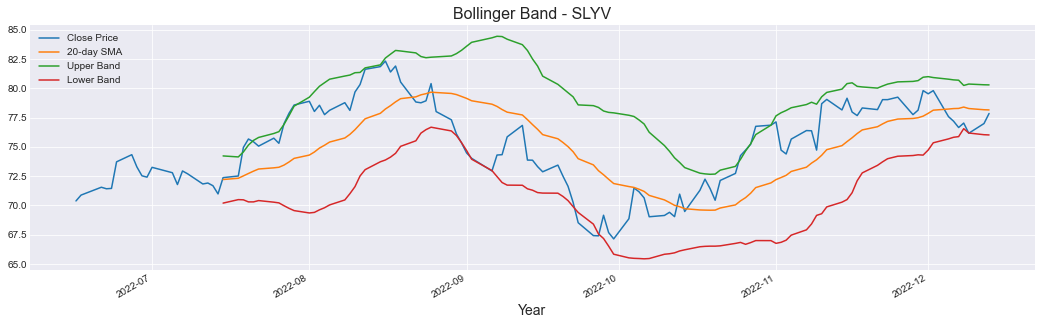

In [17]:
bollinger_band_chart(slyv_bollinger_table,'SLYV');

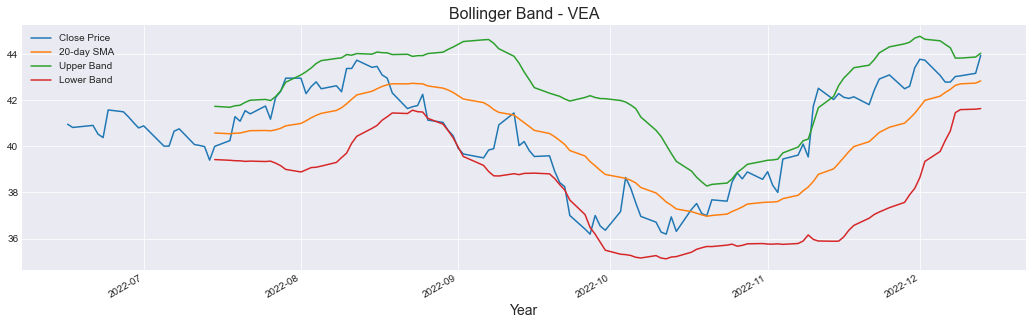

In [18]:
bollinger_band_chart(vea_bollinger_table,'VEA');

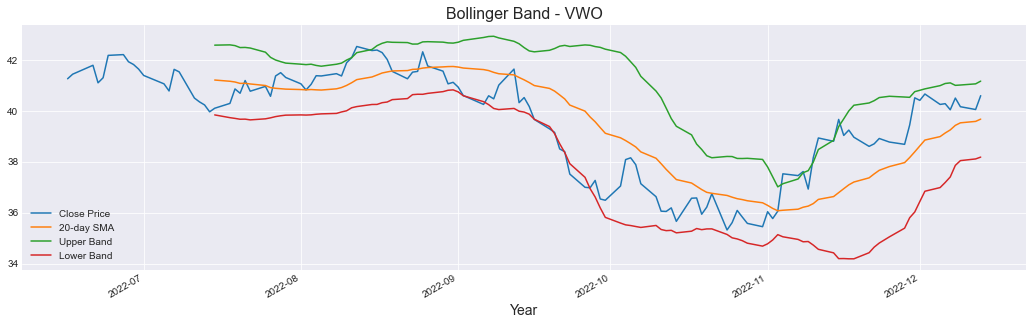

In [19]:
bollinger_band_chart(vwo_bollinger_table,'VWO');

## Exporting Data

In [20]:
sql_password = os.getenv('sql_password')
user = "lenagrumbach"
password = sql_password
url_banco = "localhost"
nome_db = "finance_api"
conn_str = f"mysql+pymysql://{user}:{password}@{url_banco}/{nome_db}"
engine = db.create_engine(conn_str)

In [21]:
df_etf.to_sql(name='df_etf', con=engine,if_exists='replace', index=False)

3765

In [22]:
df_etf_norm.to_sql(name='df_etf_norm', con=engine,if_exists='replace', index=False)

3765

In [23]:
df_etf.to_excel('df_etf.xlsx', index=False)

In [24]:
df_etf_norm.to_excel('df_etf_norm.xlsx', index=False)

In [25]:
df_5d.to_excel('df_5d.xlsx', index=False)

## Sending emails

In [26]:
# importing data for e-mail send list.

stakeholder_list =  pd.read_excel('stakeholder_list.xlsx')
active_emails = stakeholder_list.loc[stakeholder_list['Active']=='ok']

In [27]:
table_email = build_table(df_5d.reset_index(), color='blue_light', font_size='12px')

In [28]:
logging.basicConfig(level = logging.INFO, filename= 'email_report.log', encoding='utf-8')

In [29]:
def send_email(send_to, send_from='lena.dataanalyst@gmail.com', subject='Daily update'):
    dotenv.load_dotenv('senhas.env')
    gmail_password = os.getenv('gmail_password')

    body_email = f"""
    <p>Hello,

    <p> Please see below for updated information.

    {table_email}


    <p>Kind regards,
    <p>Lena Grumbach
    </p>
    """
    msg= MIMEMultipart()
    msg['Subject'] = subject
    msg['From'] = send_from
    msg['To'] = send_to
    msg.attach(MIMEText(body_email, 'html'))
    
    file_path = "C:/Users/lenag/OneDrive/Desktop/IRONHACK/Projetos/investment_analysis_project/pipeline_project/df_5d.xlsx"
    attachment = open(file_path, 'rb')
    att = MIMEBase('application','octet-stream')
    att.set_payload(attachment.read())
    encoders.encode_base64(att)
    att.add_header('Content-Disposition', f"attachment; filename=last_update.xlsx")
    attachment.close()
    msg.attach(att)

    host = 'smtp.gmail.com'
    port = '587'
    login = send_from
    password = gmail_password
    server = smtplib.SMTP(host,port)
    server.ehlo()
    server.starttls()
    server.login(login,password)
    server.sendmail(msg['From'], msg['To'], msg.as_string().encode('utf-8'))
    server.quit()

In [30]:
# Send with log file.

send_list = list(active_emails['Contact']) 
confirm_list = []
for i in send_list:
    send_email(i)
    confirm_list.append(f"Sent to {i} at {datetime.today()}")
logging.info(confirm_list)
print('done')

done
